In [ ]:
!pip install -q boto3
!pip install -q xgboost==0.90

In [1]:
import boto3
import sagemaker
import pandas as pd

sess   = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name='sagemaker', region_name=region)

# Copy the datasets from S3 to this notebook instance

In [2]:
# $S3_BUCKET/feature-store/amazon-reviews/balanced-tfidf-without-header/data.csv

prefix_train = 'feature-store/amazon-reviews/csv/balanced-tfidf-without-header/train'
prefix_validation = 'feature-store/amazon-reviews/csv/balanced-tfidf-without-header/validation'
prefix_test = 'feature-store/amazon-reviews/csv/balanced-tfidf-without-header/test'

balanced_tfidf_without_header_train_path = './{}'.format(prefix_train)
balanced_tfidf_without_header_validation_path = './{}'.format(prefix_validation)
balanced_tfidf_without_header_test_path = './{}'.format(prefix_test)

import os
os.makedirs(prefix_train, exist_ok=True)
os.makedirs(prefix_validation, exist_ok=True)
os.makedirs(prefix_test, exist_ok=True)

balanced_tfidf_without_header_train_s3_uri = 's3://{}/{}'.format(bucket, prefix_train)
balanced_tfidf_without_header_validation_s3_uri = 's3://{}/{}'.format(bucket, prefix_validation)
balanced_tfidf_without_header_test_s3_uri = 's3://{}/{}'.format(bucket, prefix_test)

In [3]:
!aws s3 cp --recursive $balanced_tfidf_without_header_train_s3_uri $balanced_tfidf_without_header_train_path
!aws s3 cp --recursive $balanced_tfidf_without_header_validation_s3_uri $balanced_tfidf_without_header_validation_path
!aws s3 cp --recursive $balanced_tfidf_without_header_test_s3_uri $balanced_tfidf_without_header_test_path

download: s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/csv/balanced-tfidf-without-header/train/part-00000.csv to feature-store/amazon-reviews/csv/balanced-tfidf-without-header/train/part-00000.csv
download: s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/csv/balanced-tfidf-without-header/validation/part-00000.csv to feature-store/amazon-reviews/csv/balanced-tfidf-without-header/validation/part-00000.csv
download: s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/csv/balanced-tfidf-without-header/test/part-00000.csv to feature-store/amazon-reviews/csv/balanced-tfidf-without-header/test/part-00000.csv


In [4]:
# # $S3_BUCKET/feature-store/amazon-reviews/csv/scrubbed-tfidf-without-header/

# #prefix_scrubbed_train = 'feature-store/amazon-reviews/csv/scrubbed-tfidf-without-header/spark-tfidf-pca'
# prefix_scrubbed_train = 'feature-store/amazon-reviews/csv/scrubbed-tfidf-without-header/train'
# prefix_scrubbed_validation = 'feature-store/amazon-reviews/csv/scrubbed-tfidf-without-header/validation'
# prefix_scrubbed_test = 'feature-store/amazon-reviews/csv/scrubbed-tfidf-without-header/test'

# scrubbed_tfidf_without_header_train_path = './{}'.format(prefix_scrubbed_train)
# scrubbed_tfidf_without_header_validation_path = './{}'.format(prefix_scrubbed_validation)
# scrubbed_tfidf_without_header_test_path = './{}'.format(prefix_scrubbed_test)

# import os
# os.makedirs(prefix_scrubbed_train, exist_ok=True)
# os.makedirs(prefix_scrubbed_validation, exist_ok=True)
# os.makedirs(prefix_scrubbed_test, exist_ok=True)

# scrubbed_tfidf_without_header_train_s3_uri = 's3://{}/{}'.format(bucket, prefix_scrubbed_train)
# scrubbed_tfidf_without_header_validation_s3_uri = 's3://{}/{}'.format(bucket, prefix_scrubbed_validation)
# scrubbed_tfidf_without_header_test_s3_uri = 's3://{}/{}'.format(bucket, prefix_scrubbed_test)

In [5]:
# !aws s3 cp --recursive $scrubbed_tfidf_without_header_train_s3_uri $scrubbed_tfidf_without_header_train_path
# !aws s3 cp --recursive $scrubbed_tfidf_without_header_validation_s3_uri $scrubbed_tfidf_without_header_validation_path
# !aws s3 cp --recursive $scrubbed_tfidf_without_header_test_s3_uri $scrubbed_tfidf_without_header_test_path

# Load the data

In [6]:
import glob
import pandas as pd

def load_dataset(path, sep, header):
    data = pd.concat([pd.read_csv(f, sep=sep, header=header) for f in glob.glob('{}/*.csv'.format(path))], ignore_index = True)

    labels = data.iloc[:,0]
    features = data.drop(data.columns[0], axis=1)
    
    if header==None:
        # Adjust the column names after dropped the 0th column above
        # New column names are 0 (inclusive) to len(features.columns) (exclusive)
        new_column_names = list(range(0, len(features.columns)))
        features.columns = new_column_names

    return features, labels

In [7]:
# Balanced
X_train, y_train = load_dataset(path=balanced_tfidf_without_header_train_path, sep=',', header=None)
X_validation, y_validation = load_dataset(path=balanced_tfidf_without_header_validation_path, sep=',', header=None)
X_test, y_test = load_dataset(path=balanced_tfidf_without_header_test_path, sep=',', header=None)

# Scrubbed (Unbalanced)
# X_train, y_train = load_dataset(path=scrubbed_tfidf_without_header_train_path, sep=',', header=None)
# X_validation, y_validation = load_dataset(path=scrubbed_tfidf_without_header_validation_path, sep=',', header=None)
# X_test, y_test = load_dataset(path=scrubbed_tfidf_without_header_test_path, sep=',', header=None)

In [8]:
X_train.shape

(32644, 300)

In [9]:
X_train.head(5)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.868501,-0.682970,-0.155548,-0.787150,0.620613,0.266214,0.029962,-0.132981,0.509962,-0.393560,...,-0.117663,-0.066428,-1.109626,0.951014,-1.242795,1.228527,-0.112112,-0.029340,-0.450803,1.089022
1,-0.330291,-0.381714,-0.154482,-0.142617,-0.161293,-0.093103,-0.411294,1.137618,-0.381846,-0.200120,...,-0.832219,0.341962,-0.386271,0.562790,0.653448,-0.267298,-0.012778,-1.487777,-1.161332,-0.285142
2,0.346246,-0.246558,0.360986,-0.421392,0.943230,-0.314573,-0.426470,1.537349,2.505462,-0.371618,...,-0.156980,-0.512491,-0.822587,-0.070183,0.028794,-0.146458,0.567099,0.541621,-0.333327,-0.212360
3,-0.152375,0.685863,-0.718405,1.236869,-1.794824,0.767940,2.789873,0.578563,0.700046,-1.342509,...,0.279949,0.225333,0.076826,-0.350537,-0.203332,-0.140963,0.209291,0.786270,-0.302863,0.079553
4,0.830068,-0.839939,-0.744240,-0.645215,-0.268550,-0.319963,-0.011647,-0.497175,0.068059,0.010363,...,-0.941986,-2.017771,2.754011,1.666461,-1.866527,-0.231143,0.562482,-2.401413,-0.855682,-0.699752


# Train the model
_This will take a few minutes.  Please be patient._

In [10]:
import xgboost as xgb
from xgboost import XGBClassifier

objective  = 'binary:logistic'
max_depth  = 5
num_round  = 1
#scale_pos_weight=3.962284958094398 # this is the ratio majority (positive sentiment count) to minority (not positive sentiment count)

xgb_estimator = XGBClassifier(objective=objective,
                              num_round=num_round,
                              max_depth=max_depth)
#                              scale_pos_weight=scale_pos_weight)

xgb_estimator.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, num_round=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

# Save Model

In [11]:
import os

import pickle as pkl

# See https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html
# Need to save with joblib or pickle.  `xgb.save_model()` does not save feature_names
model_dir  = './models/notebook/'

os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, 'xgboost-model')

pkl.dump(xgb_estimator, open(model_path, 'wb'))

print('Wrote model to {}'.format(model_path))

Wrote model to ./models/notebook/xgboost-model


# Restore Model 
This simulates restoring a model within an application.

In [12]:
import pickle as pkl
import os

model_dir  = './models/notebook/'
model_path = os.path.join(model_dir, 'xgboost-model')

xgb_estimator_restored = pkl.load(open(model_path, 'rb'))

type(xgb_estimator_restored)

xgboost.sklearn.XGBClassifier

# Plot the feature importance for this model

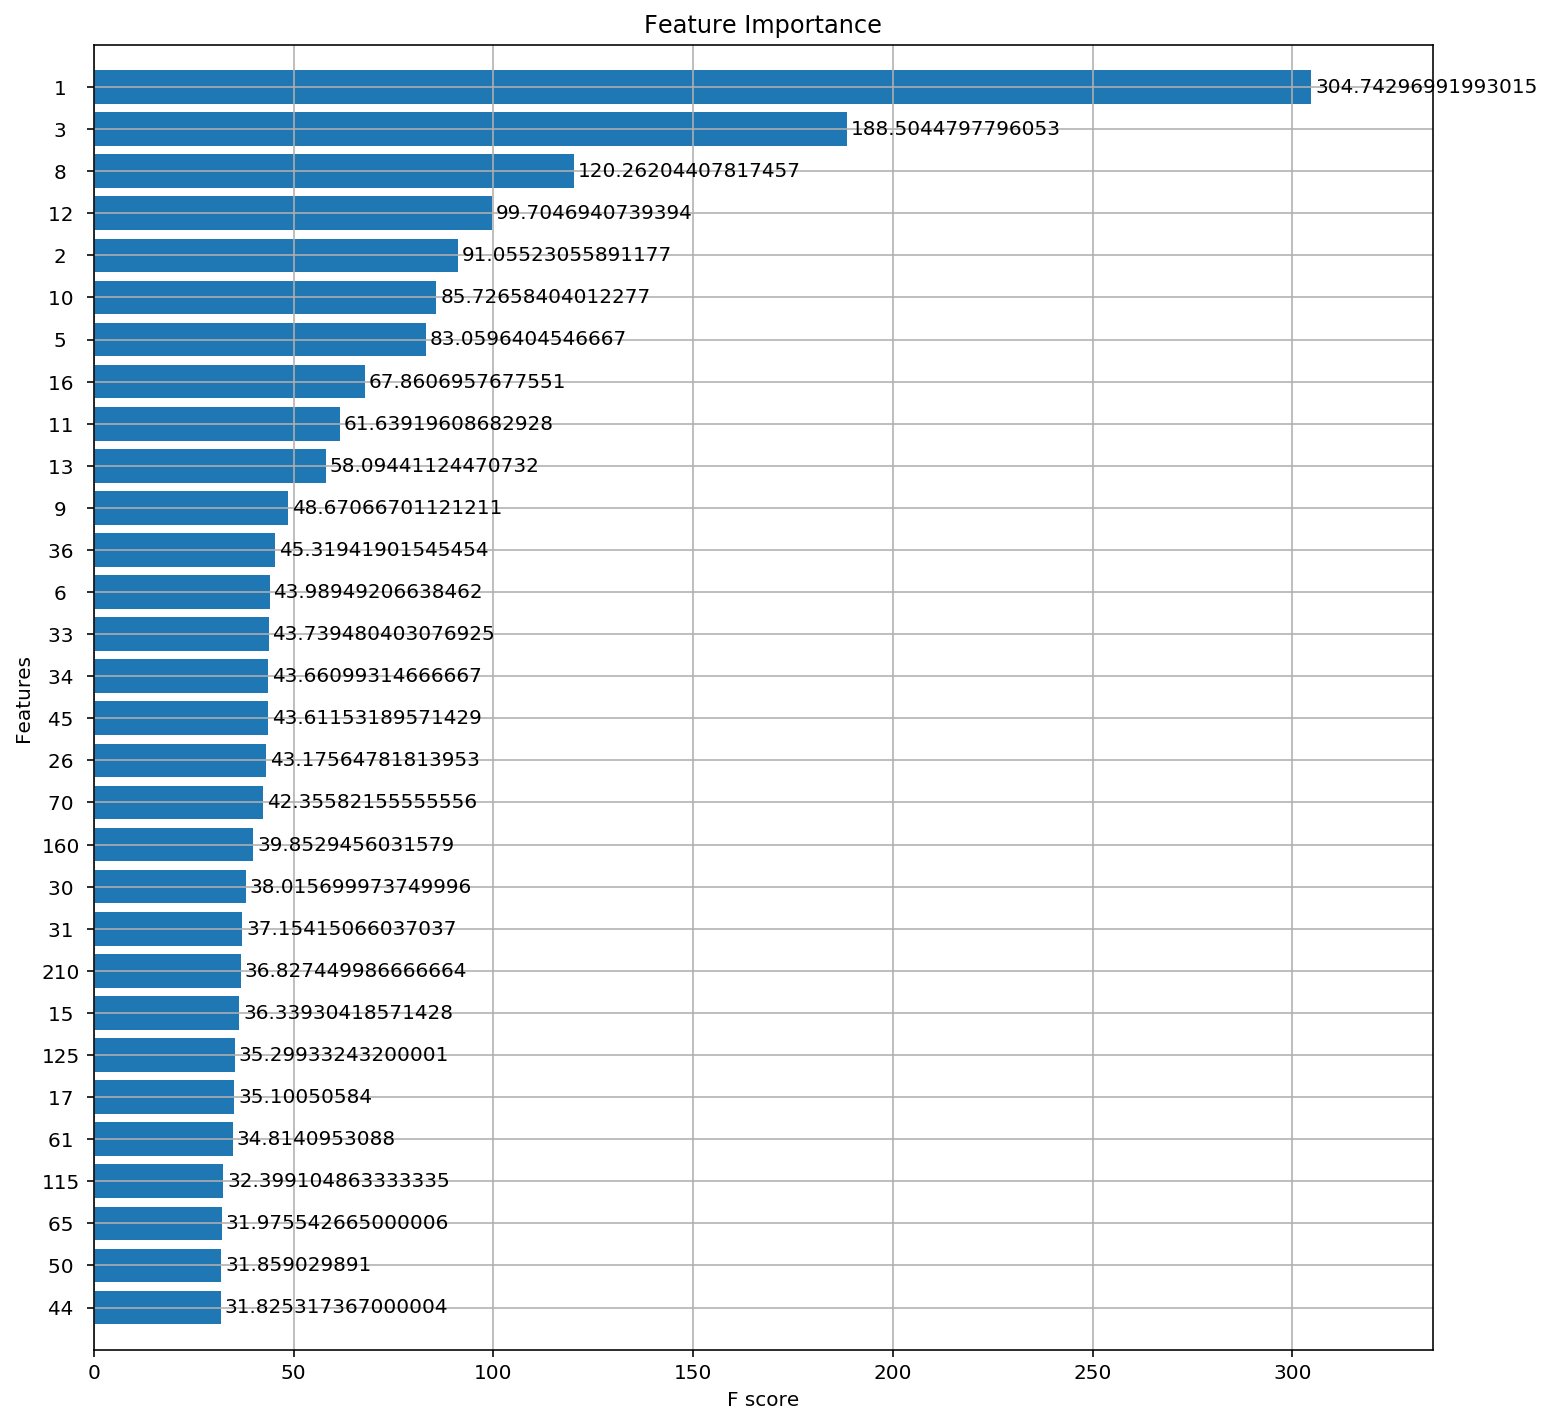

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import xgboost

fig, ax = plt.subplots(figsize=(12,12))
xgboost.plot_importance(xgb_estimator_restored, 
                        importance_type='gain', 
                        max_num_features=30, 
                        height=0.8, 
                        ax=ax, 
                        show_values = True)
plt.title('Feature Importance')
plt.show()

# Calculate Validation Metrics

In [14]:
X_validation.head(5)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.455043,-0.436823,-0.016673,-0.665743,-0.234703,-0.368054,-0.044380,0.075563,-0.441835,0.490275,...,0.015975,0.268410,-0.572401,-0.117660,-0.145316,-0.131943,0.236704,0.486233,0.520530,0.034047
1,-0.250242,-0.307113,0.353456,-0.405575,-0.084052,-0.430421,0.085044,0.082624,-0.781396,0.547700,...,0.313495,2.425779,0.922657,0.805428,-0.867564,-0.984526,-0.687393,1.341119,-0.779382,0.209968
2,0.272798,-0.664103,0.162994,-0.752852,-0.135775,-0.222743,0.082080,-0.458397,0.046522,-0.027443,...,0.324627,0.562533,-2.245786,-1.234470,-1.395703,-0.293044,0.472385,-1.364366,0.655699,2.451897
3,-1.286266,0.044399,-0.082590,0.059886,0.378059,-0.228602,0.765523,0.443970,-0.264229,-0.096345,...,0.300034,-0.074813,-0.180918,0.120401,-0.214868,0.098859,0.136307,-0.302302,-0.163209,0.111068
4,0.476977,-0.044614,-1.201439,1.100578,0.776703,-0.783058,0.827858,-0.334724,-0.943602,0.423435,...,0.694464,-1.377592,-0.626864,0.526181,-0.066672,0.353223,-0.380130,0.400697,-0.493887,0.058565


In [15]:
preds_validation = xgb_estimator_restored.predict(X_validation)
preds_validation.shape

(1814,)

In [16]:
import numpy as np
preds_validation_0_or_1 = np.where(preds_validation > 0.5, 1, 0)
preds_validation_0_or_1.shape

(1814,)

In [17]:
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix

print('Validation Accuracy: ', accuracy_score(y_validation, preds_validation_0_or_1))
print('Validation Precision: ', precision_score(y_validation, preds_validation_0_or_1, average=None))

Validation Accuracy:  0.695148842337376
Validation Precision:  [0.71325301 0.67987805]


In [18]:
pd.DataFrame(preds_validation).head(5)

,0
0,0
1,1
2,0
3,1
4,1


In [19]:
print(classification_report(y_validation, preds_validation_0_or_1))

              precision    recall  f1-score   support

           0       0.71      0.65      0.68       907
           1       0.68      0.74      0.71       907

   micro avg       0.70      0.70      0.70      1814
   macro avg       0.70      0.70      0.69      1814
weighted avg       0.70      0.70      0.69      1814



In [20]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm_validation = confusion_matrix(y_validation, preds_validation_0_or_1)
df_cm_validation

array([[592, 315],
       [238, 669]])

[[592 315]
 [238 669]]


<Figure size 432x288 with 0 Axes>

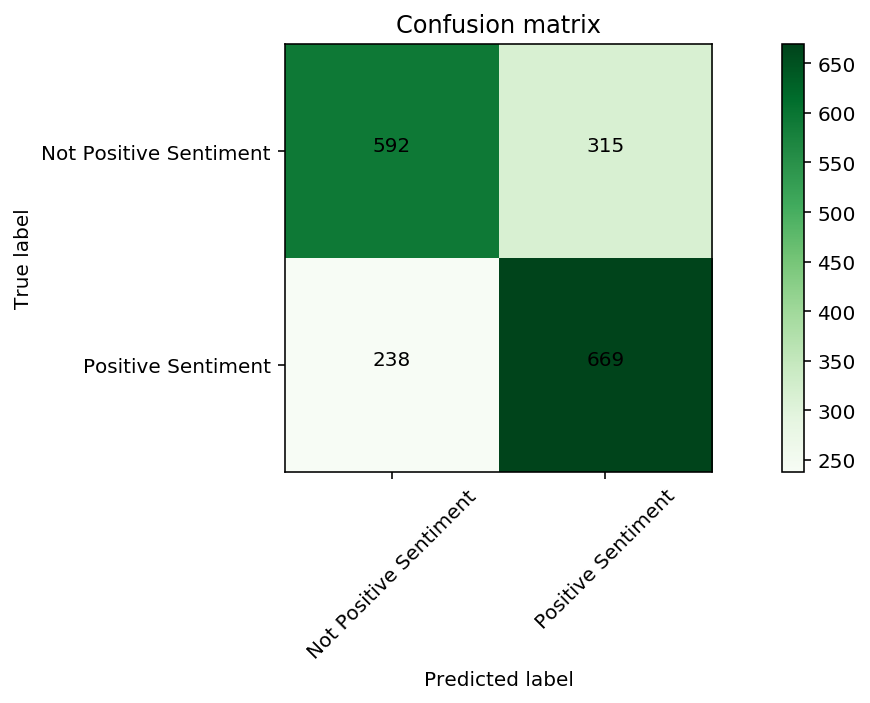

In [21]:
import itertools
import numpy as np

def plot_conf_mat(cm, classes, title, cmap = plt.cm.Greens):
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="black" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
plt.figure()
fig, ax = plt.subplots(figsize=(10,5))
plot_conf_mat(df_cm_validation, classes=['Not Positive Sentiment', 'Positive Sentiment'], 
                          title='Confusion matrix')
plt.show()

AUC is 0.6951


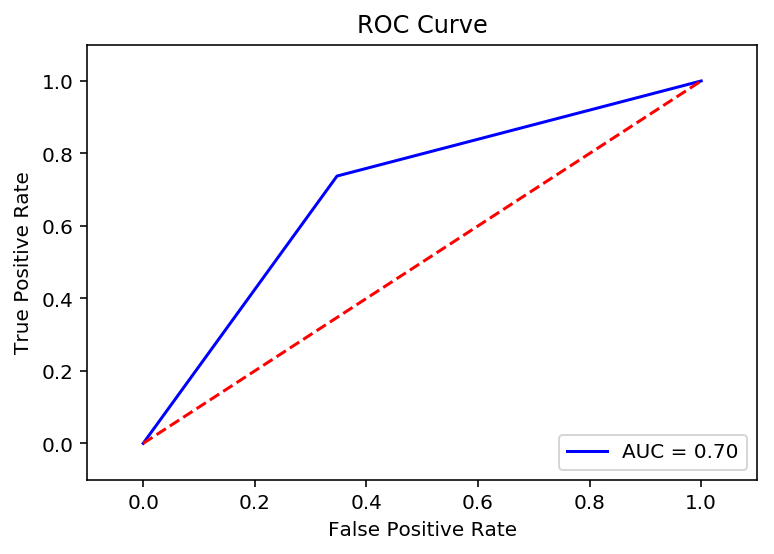

In [22]:
from sklearn import metrics

#print(metrics.f1_score(y_validation, preds_validation))

auc = round(metrics.roc_auc_score(y_validation, preds_validation_0_or_1), 4)
print('AUC is ' + repr(auc))

fpr, tpr, _ = metrics.roc_curve(y_validation, preds_validation_0_or_1)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Calculate Test Metrics

In [23]:
X_test.head(5)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,2.383201,0.287006,5.391172,0.378016,0.864490,1.978343,-1.329946,1.376201,-0.013404,0.663461,...,0.010303,0.124662,0.160485,-0.080119,0.022302,0.010848,0.075164,-0.085988,0.287493,-0.119263
1,-0.392823,-0.364012,-0.415852,-0.390032,-0.442956,0.259449,-0.418195,0.001143,-0.472477,-0.277370,...,-0.472767,0.469055,2.452907,-0.743232,-1.655371,0.066450,1.552562,0.006090,1.387517,2.365324
2,0.253595,-0.689303,-0.704973,-0.412949,-0.674179,0.347468,-0.610323,0.138149,-0.496851,-0.552126,...,-0.795384,-0.844647,-0.678710,-0.469121,0.232318,0.298030,0.822904,-0.238368,-1.997666,0.429413
3,0.744328,3.626899,-0.696094,-0.368917,-0.562515,-0.608401,-0.068564,-2.484014,-1.355456,-1.668083,...,-0.530316,-0.222006,0.098043,-0.026311,-0.312629,-0.360322,0.238167,-0.300922,-0.169838,-0.148596
4,-1.576102,0.082530,0.094707,-0.024530,-0.024758,0.070597,-0.088477,0.003164,-0.036715,-0.045996,...,0.005700,-0.014636,-0.003693,0.010210,-0.018319,-0.029472,-0.000404,-0.002602,0.015595,-0.008816


In [24]:
preds_test = xgb_estimator_restored.predict(X_test)


In [44]:
preds_test

array([1, 0, 0, ..., 1, 1, 1])

In [25]:
import numpy as np
preds_test_0_or_1 = np.where(preds_test > 0.5, 1, 0)
preds_test_0_or_1.shape

(1814,)

In [26]:
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix

print('Test Accuracy: ', accuracy_score(y_test, preds_test_0_or_1))
print('Test Precision: ', precision_score(y_test, preds_test_0_or_1, average=None))

Test Accuracy:  0.6742006615214995
Test Precision:  [0.67062635 0.67792793]


In [27]:
print(classification_report(y_test, preds_test_0_or_1))

              precision    recall  f1-score   support

           0       0.67      0.68      0.68       907
           1       0.68      0.66      0.67       907

   micro avg       0.67      0.67      0.67      1814
   macro avg       0.67      0.67      0.67      1814
weighted avg       0.67      0.67      0.67      1814



In [28]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm_test = confusion_matrix(y_test, preds_test_0_or_1)
df_cm_test

array([[621, 286],
       [305, 602]])

[[621 286]
 [305 602]]


<Figure size 432x288 with 0 Axes>

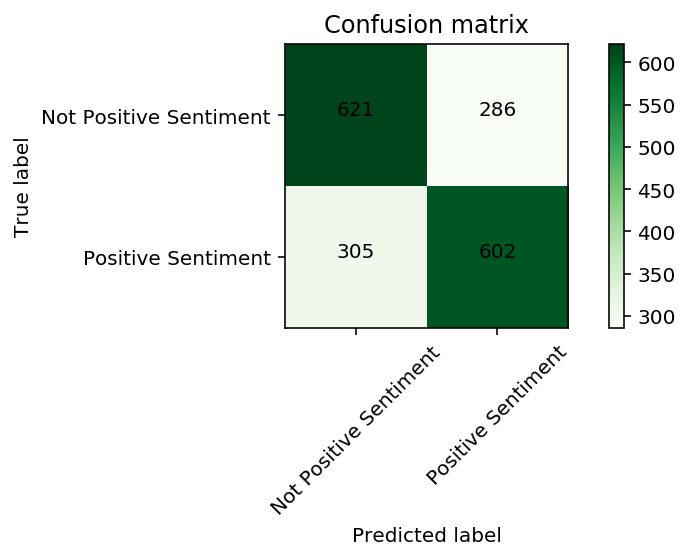

In [29]:
import itertools
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

def plot_conf_mat(cm, classes, title, cmap = plt.cm.Greens):
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="black" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
plt.figure()
fig, ax = plt.subplots(figsize=(6,4))
plot_conf_mat(df_cm_test, classes=['Not Positive Sentiment', 'Positive Sentiment'], 
                          title='Confusion matrix')
plt.show()

AUC is 0.6742


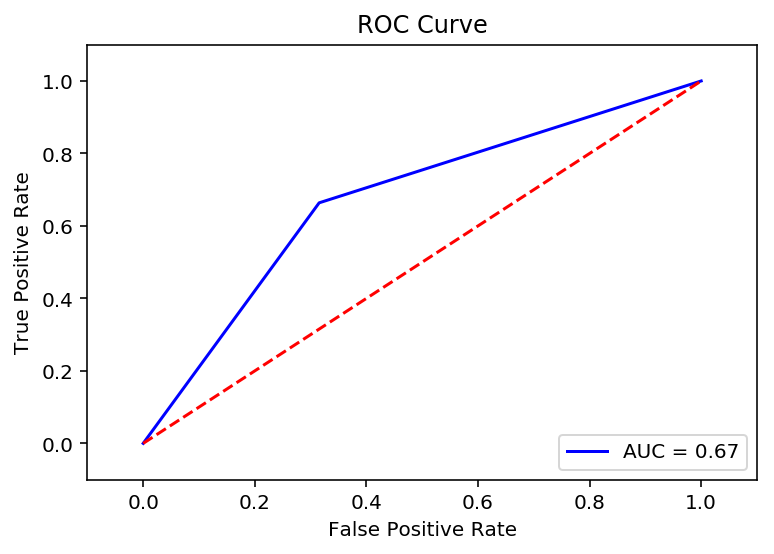

In [30]:
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

auc = round(metrics.roc_auc_score(y_test, preds_test_0_or_1), 4)
print('AUC is ' + repr(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, preds_test_0_or_1)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Predict in Notebook

Create `feature_transform_fn()` function (same used during `prepare` phase)

In [31]:
# Use TruncatedSVD vs. PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

def feature_transform_fn(df_text, column_name, num_components):
    text_processors = Pipeline(
        steps=[
            (
                'tfidfvectorizer',
                TfidfVectorizer(
                    max_df=0.25,                                       
                    min_df=.0025,
                    analyzer='word',
                    max_features=10000
                )
            )
        ]
    )

    column_transformer = ColumnTransformer(
        transformers=[('text_processing', text_processors, df_text.columns.get_loc(column_name))]
    )

    pipeline = Pipeline(
        steps=[
            ('column_transformer', column_transformer), 
            ('dimension_reducer', TruncatedSVD(n_components=num_components)),
            ('standard_scaler', StandardScaler())
        ]
    )

    return pipeline

In [32]:
# $S3_BUCKET/feature-store/amazon-reviews/scrubbed-raw-with-header

prefix_raw = 'feature-store/amazon-reviews/csv/scrubbed-raw-with-header/test'

scrubbed_raw_path = './{}'.format(prefix_raw)

import os
os.makedirs(prefix_raw, exist_ok=True)

scrubbed_raw_s3_uri = 's3://{}/{}'.format(bucket, prefix_raw)

In [33]:
!aws s3 cp --recursive $scrubbed_raw_s3_uri $scrubbed_raw_path

download: s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/csv/scrubbed-raw-with-header/test/part-00000.csv to feature-store/amazon-reviews/csv/scrubbed-raw-with-header/test/part-00000.csv


In [34]:
X_raw, y_raw = load_dataset(path=scrubbed_raw_path, sep=',', header=0)
X_raw.head(5)

,review_body
0,Tedious and long. Interesting the first half b...
1,Best series on TV. I have watched it many tim...
2,"Like it, could be very nice"
3,Movie was very interesting Jennifer did a grea...
4,Love it


In [35]:
y_raw.head(5)

0    0
1    1
2    1
3    0
4    1
Name: is_positive_sentiment, dtype: int64

In [36]:
np_tfidf = feature_transform_fn(df_text=X_raw, column_name='review_body', num_components=300).fit_transform(X_raw)
df_tfidf = pd.DataFrame(np_tfidf)
df_tfidf.shape

(4500, 300)

In [37]:
df_tfidf.head(5)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.016632,-0.562782,-0.309030,-0.810542,-0.515300,-0.013478,-0.132476,-0.220535,-0.586983,-0.288144,...,0.795551,-0.754408,1.386926,-0.203474,-2.875660,-0.139708,0.712049,0.760914,-0.634393,-0.426373
1,-0.710952,-0.071677,0.051312,-0.446348,-0.012972,-0.157743,0.519543,-0.319599,0.512325,-0.444254,...,-1.873967,0.284973,1.216124,-1.240356,-2.932468,-1.931438,-1.918193,0.374471,-2.425009,-2.590096
2,-0.671206,-0.240987,-0.279774,-0.162433,0.088788,-0.226124,-0.151453,0.093122,-0.186884,2.203671,...,0.158282,-0.410267,-0.248350,-0.589603,-0.291561,-1.351685,0.126443,0.030541,-0.019766,0.107545
3,0.704037,0.726646,-0.771889,0.139849,-0.865496,-0.126313,-0.326784,-0.012983,-0.387895,2.059199,...,0.229591,-0.857026,-1.521468,0.635810,0.664560,-2.027206,1.266593,-2.378990,-2.200871,0.888908
4,0.438346,-1.060365,4.058494,3.347166,-1.862291,-1.429176,1.349544,-0.072433,0.347699,0.229980,...,0.014289,0.084221,0.121553,-0.121190,-0.002369,-0.054224,0.117766,-0.019021,-0.027227,0.021636


In [38]:
X_raw.head(5)

,review_body
0,Tedious and long. Interesting the first half b...
1,Best series on TV. I have watched it many tim...
2,"Like it, could be very nice"
3,Movie was very interesting Jennifer did a grea...
4,Love it


In [39]:
y_raw.head(5)

0    0
1    1
2    1
3    0
4    1
Name: is_positive_sentiment, dtype: int64

In [40]:
preds_raw = xgb_estimator_restored.predict(df_tfidf)
df_preds_raw = pd.DataFrame(preds_raw)
df_preds_raw.head(5)

,0
0,0
1,0
2,1
3,1
4,1


In [41]:
import numpy as np
preds_raw_0_or_1 = np.where(preds_raw > 0.5, 1, 0)
preds_raw_0_or_1.shape

(4500,)

In [42]:
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix

print('Test Accuracy: ', accuracy_score(y_raw, preds_raw_0_or_1))
print('Test Precision: ', precision_score(y_raw, preds_raw_0_or_1, average=None))

Test Accuracy:  0.5711111111111111
Test Precision:  [0.22514777 0.81508147]


In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm_raw = confusion_matrix(y_raw, preds_raw_0_or_1)
df_cm_raw

In [ ]:
import itertools

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

def plot_conf_mat(cm, classes, title, cmap = plt.cm.Greens):
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="black" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
plt.figure()
fig, ax = plt.subplots(figsize=(6,4))
plot_conf_mat(df_cm_raw, classes=['Not Positive Sentiment', 'Positive Sentiment'], 
                          title='Confusion matrix')
plt.show()

In [ ]:
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

auc = round(metrics.roc_auc_score(y_raw, preds_raw_0_or_1), 4)
print('AUC is ' + repr(auc))

fpr, tpr, _ = metrics.roc_curve(y_raw, preds_raw_0_or_1)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()